In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import glob

In [3]:
file_list = glob.glob("/data0/users/bpnachman/anomaly/bigger/processed_lhe*.txt")

In [4]:
file_list

['/data0/users/bpnachman/anomaly/bigger/processed_lhe005_background.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe004_background.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe001_background.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe006_background.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe007_background.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe002_background.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe008_background.txt',
 '/data0/users/bpnachman/anomaly/bigger/processed_lhe003_background.txt']

In [5]:
#"Background only" i.e. no anomalies in this dataset
myfile = open("/data0/users/bpnachman/anomaly/processed_lhe001_background.txt")

#Want to make new particles with a given mass.  E = mc^2
#Instead electron + electron -> new particle -> stuff we sift through
#electron + electron -> photon + new particle -> stuff



def parse_file(file_object):
    all_records = []
    mymeasuredenergy = []

    count = 0
    for line in file_object:

        metadata = line.split("J")[0]
        eventinfo = line.split("J")[1]
        jets = eventinfo.split("P")[0]
        particles = eventinfo.split("P")[1]

        this_record = {}
        this_record['label'] = count
        count += 1
        eventweight = float(metadata.split()[0])
        this_record['eventweight'] = eventweight #this is the event "weight".  Let's ignoreit for now (we will need it later).
        njets = int(len(jets.split())/11) #number of "jets"

        nparticles  = int(len(particles.split())/5) #number of particles




        #True collision quantities
        this_record['truthcenterofmassenergy'] = float(metadata.split()[1]) #true total energy - should be delta function at 1000 GeV
        this_record['truthsqrtshat'] = float(metadata.split()[2]) #energy available for making new particles (electron energy - photon)
        this_record['truthphotonpT'] = float(metadata.split()[3]) #photon momentum |p| in units of GeV
        this_record['truthphotoneta'] = float(metadata.split()[4]) #photon pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
        this_record['truthphotonphi'] = float(metadata.split()[5]) #photon azimuthal angle

        #Measured collision quantities
        measuredcenterofmassenergy  = float(metadata.split()[6]) #true measured energy - should be noisy version of truthcenterofmassenergy
        this_record['measuredcenterofmassenergy'] = measuredcenterofmassenergy
        this_record['measuredsqrtshat'] = float(metadata.split()[7]) #energy available for making new particles (electron energy - photon)
        this_record['measuredphotonpT'] = float(metadata.split()[8]) #photon momentum |p| in units of GeV
        this_record['measuredphotoneta'] = float(metadata.split()[9]) #photon pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
        this_record['measuredphotonphi'] = float(metadata.split()[10]) #photon azimuthal angle
        this_record['metadata'] = metadata.split()

        mymeasuredenergy+=[measuredcenterofmassenergy]

        this_record['njets'] = njets
        jets = jets.split()
        jets_vec = []
        for i in range(njets):
            jet = np.zeros(11)
            #order:
            # - index
            # - magnitude of momentum |p| (units of GeV)
            # - pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
            # - azimuthal angle
            # - mass (units of GeV/c^2)
            # - bit encoding of the jet "flavor" (not totally sure what the bit means, but will look it up)
            # - 0th angular moment of jet radiation
            # - 1th angular moment of jet radiation
            # - 2th angular moment of jet radiation
            # - 3th angular moment of jet radiation
            # - 4th angular moment of jet radiation
            jet = jets[i*11:i*11+11]
            jets_vec+=[jet]

        this_record['jets']=jets_vec

        this_record['nparticles'] = nparticles

        particles = particles.split()
        particles_vec = []
        for i in range(nparticles):
            particle = np.zeros(5)
            #order:
            # - index
            # - magnitude of momentum |p| (units of GeV)
            # - pseudorapidity (~polar angle - see e.g. https://en.wikipedia.org/wiki/Pseudorapidity)
            # - azimuthal angle
            # - particle identifier (https://pdg.lbl.gov/2006/reviews/pdf-files/montecarlo-web.pdf)
            particle = particles[i*5:i*5+5]
            particles_vec+=[particle]
            #print(particles[i*5],particles[i*5+1],particles[i*5+2],particles[i*5+3],particles[i*5+4])
        this_record['particles'] = particles_vec

        all_records.append(this_record)
    return all_records

In [6]:
all_records = []
for filename in file_list:
    file = open(filename)
    all_records += parse_file(file)

In [7]:
len(all_records)

79999

Text(0, 0.5, 'Number of Events / bin')

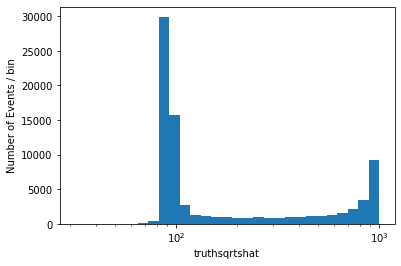

In [8]:
this_arr = np.array([i['truthsqrtshat'] for i in all_records])
plt.hist(this_arr, bins=np.logspace(1.5,3,30))
plt.xscale('log')
plt.xlabel("truthsqrtshat")
plt.ylabel("Number of Events / bin")


In [9]:
len(this_arr[(this_arr>300)*(this_arr<400)])


2262

## EFN experimenting

### imports and settings

In [10]:
import energyflow as ef
from energyflow.archs import PFN
from energyflow.datasets import qg_jets
from energyflow.utils import data_split, remap_pids, to_categorical
from sklearn.metrics import roc_auc_score, roc_curve


Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

### Save particles only as X

Save all particles in 3d array. dim 0 = datapoints; dim 1 = particles; dim 2 = particle features.

Particle features have original index 0 omitted. new index 0, 1, 2 are numerical. index 3 is PID

In [11]:
max_nparticles = max([i['nparticles'] for i in all_records])

In [12]:
padded_part_arrays =[]
for record in all_records:
    # convert to np array
    these_particles = np.array(record['particles']).astype('float')
    # omit index 0
    these_particles = these_particles[:,1:]
    # determine how many zero values to pad
    pad_length = max_nparticles - these_particles.shape[0]
    #pad
    padded_particles = np.pad(these_particles, ((0,pad_length),(0,0)))
    # check padding
    assert padded_particles.shape == (max_nparticles, 4)
    # add to list
    padded_part_arrays.append(padded_particles)
    
all_particle_array = np.array(padded_part_arrays)
X = all_particle_array

In [13]:
X.shape

(79999, 260, 4)

### Save jets as Z

In [58]:
all_records[0]['jets']

[['0',
  '189.98',
  '-1.62299',
  '1.02308',
  '89.4432',
  '0',
  '0.429496',
  '0.0397034',
  '0.0308161',
  '0.0261881',
  '0.0196577']]

In [55]:
max_njets = max([i['njets'] for i in all_records])

In [71]:
padded_jet_arrays =[]
for record in all_records:
    # convert to np array
    these_jets = np.array(record['jets']).astype('float')
    # omit index 0
    if len(these_jets) == 0:
        these_jets = np.zeros(11).reshape([1,11])
    these_jets = these_jets[:,1:]
        
    # determine how many zero values to pad
    pad_length = max_njets - these_jets.shape[0]
    #pad
    padded_jets = np.pad(these_jets, ((0,pad_length),(0,0)))
    # check padding
    assert padded_jets.shape == (max_njets, 10)
    # add to list
    padded_jet_arrays.append(padded_jets)
    
all_jet_array = np.array(padded_jet_arrays)
Z = all_jet_array

In [72]:
Z.shape

(79999, 8, 10)

### Save measured truthsqrtshat as y

In [14]:
y = np.array([i['truthsqrtshat'] for i in all_records])

In [15]:
y.shape

(79999,)

### Identify signal & side band

In [32]:
side_band_left = 180
side_band_right = 470
signal_left = 250
signal_right = 400
def binary_side_band(y_thing):
    if y_thing >= signal_left and y_thing < signal_right:
        return 1
    elif y_thing >= side_band_left and y_thing < side_band_right:
        return 0
    else:
        return -1


In [33]:
y_binary = np.vectorize(binary_side_band)(y)

In [34]:
np.unique(y_binary,return_counts = True)

(array([-1,  0,  1]), array([72429,  3899,  3671]))

In [35]:
within_bounds_indicator = y_binary >= 0

In [36]:
np.unique(within_bounds_indicator,return_counts = True)

(array([False,  True]), array([72429,  7570]))

### Select signal & side band data points

In [37]:
X_selected = X[within_bounds_indicator]
y_selected = y_binary[within_bounds_indicator]

### Preprocessing

In [38]:
X_selected.shape

(7570, 260, 4)

In [39]:
X_selected.mean()

16.305074269481764

In [40]:
train, val, test = 7000, 500, 70
use_pids = True


In [41]:
# center and normalize
X_normalized = np.copy(X_selected)
for x in X_normalized:
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()


In [42]:
# handle particle id channel
if use_pids:
    remap_pids(X_normalized, pid_i=3)
else:
    X_normalized = X_normalized[:,:,:3]

In [43]:
# categorize y
Y = to_categorical(y_selected, num_classes=2)

In [44]:
# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X_normalized, Y, val=val, test=test)

### Building the model

In [50]:
Phi_sizes, F_sizes = (10, 10, 16), (20, 20)
num_epoch = 30
batch_size = 10

In [53]:
# build architecture
pfn = PFN(input_dim=X.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 10)     50          input[0][0]                      
__________________________________________________________________________________________________
activation_25 (Activation)      (None, None, 10)     0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 10)     110         activation_25[0][0]              
__________________________________________________________________________________________________
activation

In [54]:
pfn

### Training

In [52]:
pfn.fit(X_train, Y_train,
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_val, Y_val),
          verbose=1)

Train on 7000 samples, validate on 500 samples
Epoch 1/30
7000/7000 [==============================] - 6s 810us/step - loss: 1.2256 - acc: 0.5031 - val_loss: 0.7747 - val_acc: 0.4780
Epoch 2/30
7000/7000 [==============================] - 5s 698us/step - loss: 0.7478 - acc: 0.5243 - val_loss: 0.7192 - val_acc: 0.5140
Epoch 3/30
7000/7000 [==============================] - 5s 689us/step - loss: 0.7232 - acc: 0.5247 - val_loss: 0.6920 - val_acc: 0.5320
Epoch 4/30
7000/7000 [==============================] - 5s 688us/step - loss: 0.7076 - acc: 0.5170 - val_loss: 0.7243 - val_acc: 0.5020
Epoch 5/30
7000/7000 [==============================] - 5s 667us/step - loss: 0.7033 - acc: 0.5173 - val_loss: 0.7263 - val_acc: 0.4880
Epoch 6/30
7000/7000 [==============================] - 4s 584us/step - loss: 0.6985 - acc: 0.5076 - val_loss: 0.6962 - val_acc: 0.4940
Epoch 7/30
7000/7000 [==============================] - 4s 586us/step - loss: 0.6965 - acc: 0.5196 - val_loss: 0.6928 - val_acc: 0.4920
E

In [31]:
#Later for ML: https://energyflow.network/examples/